<a href="https://colab.research.google.com/github/40434wendy/meridian/blob/main/meridian_20250714.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/meridian/blob/main/demo/Meridian_Getting_Started.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/meridian/blob/main/demo/Meridian_Getting_Started.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

<a name="install"></a>
## Step 0: Install

In [ ]:
# Install meridian
!pip install --upgrade git+https://github.com/google/meridian.git

  Cloning https://github.com/google/meridian.git to /tmp/pip-req-build-fvh8ce04
  Running command git clone --filter=blob:none --quiet https://github.com/google/meridian.git /tmp/pip-req-build-fvh8ce04
  Resolved https://github.com/google/meridian.git to commit 8841189e353801507562db4543a8999130394fdd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for google-meridian: filename=google_meridian-1.1.5-py3-none-any.whl size=388553 sha256=94e3e57a1e64da781730178d8f7418752859c883c38b1cf341530c82e15d6957
  Stored in directory: /tmp/pip-ephem-wheel-cache-ac0nkac_/wheels/bf/75/52/7f5d2ed8f45a6c19d5961d17d9a0fed3e0ac766881ba542da0
Successfully built google-meridian
  Attempting uninstall: natsort
    Found existing installation: natsort 8.4.0
    Uninstalling natsort-8.4.0:
      Successfully uninstalled natsort-8.4.0


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 13.6 gigabytes of available RAM

Num GPUs Available:  1
Num CPUs Available:  1


## Step 1: Collect Data

In [ ]:
# Load stimulated data from github
df = pd.read_csv("https://raw.githubusercontent.com/google/meridian/refs/heads/main/meridian/data/simulated_data/csv/geo_all_channels.csv",
          index_col=0)
display(df.head())
display(df.info())

,geo,time,Channel0_impression,Channel1_impression,Channel2_impression,Channel3_impression,Channel4_impression,competitor_sales_control,sentiment_score_control,Channel0_spend,Channel1_spend,Channel2_spend,Channel3_spend,Channel4_spend,Organic_channel0_impression,Promo,conversions,revenue_per_conversion,population
0,Geo0,2021-01-25,280668,0,0,470611,108010,-1.338765,0.115581,2058.0608,0.00000,0.00000,3667.3965,841.6044,97320,0.000000,1954576.8,0.020055,136670.94
1,Geo0,2021-02-01,366206,182108,19825,527702,252506,0.893645,0.944224,2685.2874,1755.74540,147.31808,4112.2974,1967.5044,201441,0.000000,2064249.6,0.020103,136670.94
2,Geo0,2021-02-08,197565,230170,0,393618,184061,-0.284549,-1.290579,1448.6895,2219.12230,0.00000,3067.4023,1434.1870,0,0.683819,2086382.8,0.019929,136670.94
3,Geo0,2021-02-15,140990,66643,0,326034,201729,-1.034740,-1.084514,1033.8406,642.52057,0.00000,2540.7310,1571.8545,0,1.289055,2826431.5,0.019987,136670.94
4,Geo0,2021-02-22,399116,164991,0,381982,153973,-0.319276,-0.017503,2926.6072,1590.71640,0.00000,2976.7249,1199.7440,0,0.227739,3551929.2,0.020000,136670.94


<class 'pandas.core.frame.DataFrame'>
Index: 6240 entries, 0 to 6239
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geo                          6240 non-null   object 
 1   time                         6240 non-null   object 
 2   Channel0_impression          6240 non-null   int64  
 3   Channel1_impression          6240 non-null   int64  
 4   Channel2_impression          6240 non-null   int64  
 5   Channel3_impression          6240 non-null   int64  
 6   Channel4_impression          6240 non-null   int64  
 7   competitor_sales_control     6240 non-null   float64
 8   sentiment_score_control      6240 non-null   float64
 9   Channel0_spend               6240 non-null   float64
 10  Channel1_spend               6240 non-null   float64
 11  Channel2_spend               6240 non-null   float64
 12  Channel3_spend               6240 non-null   float64
 13  Channel4_spend         

None

In [ ]:
# check the structure of df
print('【var : uniques】')
for col in df.columns:
  print(f'{col} : {len(df[col].unique())}')

【var : uniques】
geo : 40
time : 156
Channel0_impression : 5483
Channel1_impression : 4491
Channel2_impression : 2226
Channel3_impression : 6069
Channel4_impression : 5416
competitor_sales_control : 6240
sentiment_score_control : 6239
Channel0_spend : 5483
Channel1_spend : 4491
Channel2_spend : 2226
Channel3_spend : 6069
Channel4_spend : 5416
Organic_channel0_impression : 4164
Promo : 3319
conversions : 6240
revenue_per_conversion : 6134
population : 40


* 40 geo x 156 weeks
* treatment (by geo x time) : ch0~ch4, organic_ch0, promo
* outcome (by geo x time) : conversions, revenue_per_conversion
* geo info(by geo) : population
* note : promo has fewer unique values


In [ ]:
# columns manipulation
df['time'] = pd.to_datetime(df['time'])
df['revenue'] = df['conversions'] * df['revenue_per_conversion']

# rename columns
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(r'(.*)channel(\d+)_(.*)$',r'\1ch\2_\3', regex=True)

# column groups
col_coord = ['geo','time']
col_imp = [col for col in df.columns if 'impression' in col]
col_spend = [col for col in df.columns if 'spend' in col]
col_control = ['competitor_sales_control', 'sentiment_score_control']
col_outcome = ['conversions', 'revenue']

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6240 entries, 0 to 6239
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   geo                       6240 non-null   object        
 1   time                      6240 non-null   datetime64[ns]
 2   ch0_impression            6240 non-null   int64         
 3   ch1_impression            6240 non-null   int64         
 4   ch2_impression            6240 non-null   int64         
 5   ch3_impression            6240 non-null   int64         
 6   ch4_impression            6240 non-null   int64         
 7   competitor_sales_control  6240 non-null   float64       
 8   sentiment_score_control   6240 non-null   float64       
 9   ch0_spend                 6240 non-null   float64       
 10  ch1_spend                 6240 non-null   float64       
 11  ch2_spend                 6240 non-null   float64       
 12  ch3_spend                

### check promo
* whether there has different promo strength across geo?
* how promo changes over time?

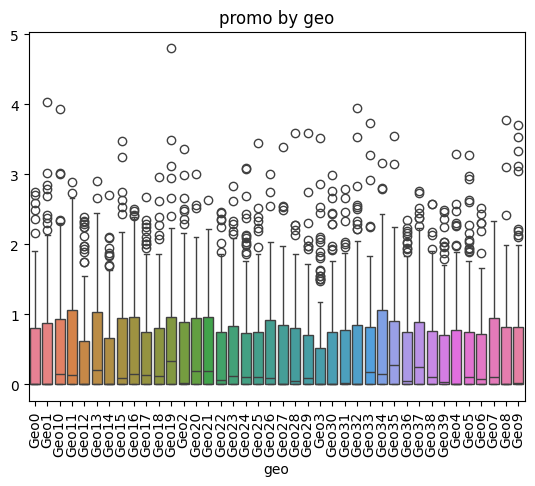

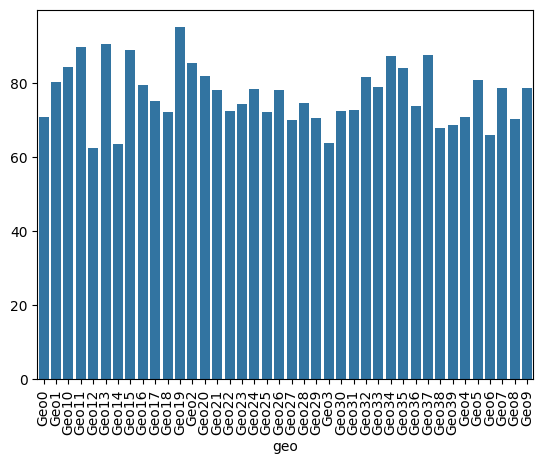

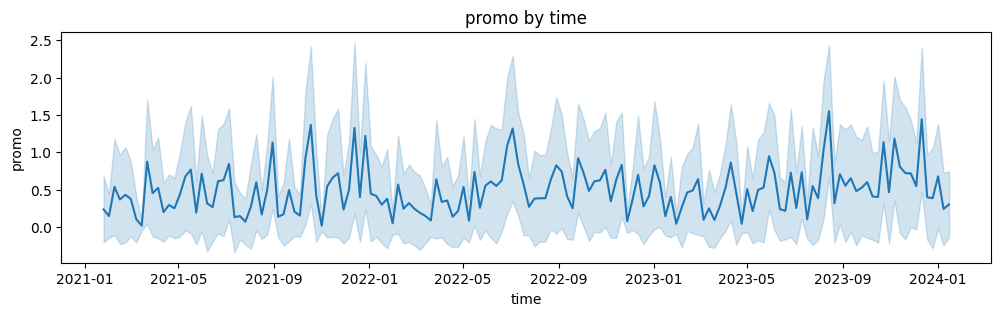

In [ ]:
# promo
promo_pivot = pd.pivot_table(df,index='time', columns='geo', values='promo')

plt.xticks(rotation=90)
sns.boxplot(promo_pivot)
plt.title('promo by geo')
plt.show()

plt.xticks(rotation=90)
sns.barplot(promo_pivot.sum(axis=0))
plt.show()

plt.figure(figsize=(12,3))
sns.lineplot(df[['geo','time','promo']], x='time', y='promo', ci='sd')
plt.title('promo by time')
plt.show()

* promo is highly skewed (median close to 0, means only 50% of the time has promos).
* there's no huge difference on promo across geos (similar means and stds).


### check geo effect (by media spend)
> check if certain geo need to be exclude from the model.

* are the channel sets the same across geos?
* does there has low spend volumn/ extremely high variance geos?
* does media effect (roas) the same across geos?

<Axes: title={'center': '% of zero spend'}>

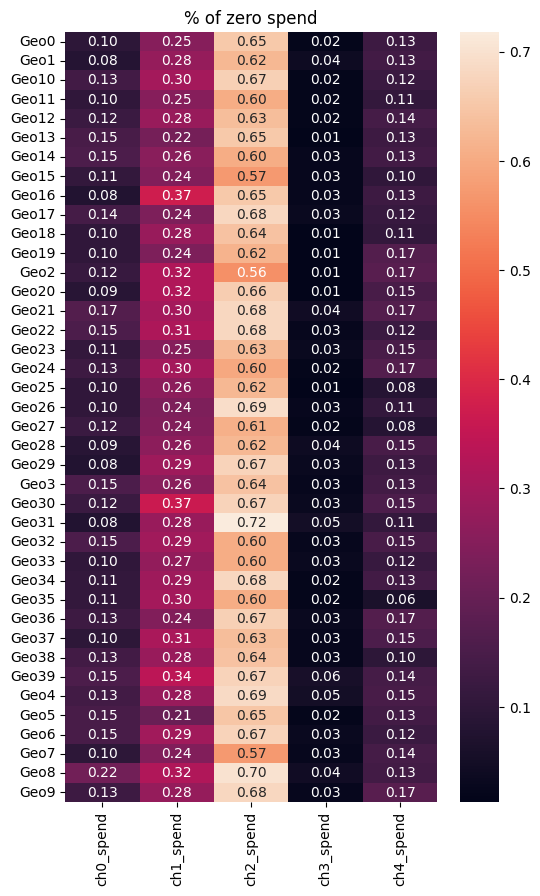

In [ ]:
# spend
## 1.check channel sets with zero-spend values
geo_zeros = pd.DataFrame()

for geo_index, da in df.groupby('geo'):
  zeros_pct = (da[col_spend]<1).sum() / len(da)
  zeros_pct = zeros_pct.to_frame().T
  zeros_pct.index = [geo_index]
  geo_zeros = pd.concat([geo_zeros, zeros_pct],axis=0)

plt.figure(figsize=(6,10))
plt.xticks(rotation=90)
plt.title('% of zero spend')
sns.heatmap(geo_zeros, annot=True, fmt='.2f')

geo,Geo23,Geo36,Geo10,Geo2,Geo31,Geo17,Geo14,Geo25,Geo35,Geo39,...,Geo4,Geo8,Geo26,Geo30,Geo38,Geo3,Geo6,Geo1,Geo24,Geo0
time,,,,,,,,,,,,,,,,,,,,,
2021-01-25,80660.5200,44253.0280,78009.0880,52749.9040,71164.793000,51139.29340,30424.6570,58493.8098,70050.5016,41731.3470,...,10408.68173,16471.5412,14931.8538,10689.0948,12887.13084,7877.1236,10562.2390,13579.472800,21851.8004,6567.06170
2021-02-01,78625.2390,72398.1060,65767.8734,78779.0730,79140.584000,27402.14860,72511.4894,71938.1820,56336.2030,65545.5136,...,10515.02223,17078.4402,11611.3204,35627.7752,29813.89130,28620.0945,11153.8155,17838.954600,9395.0262,10668.15268
2021-02-08,37441.8780,48431.0340,46203.1590,59073.4369,36982.386646,39949.45500,74970.1748,15336.3096,67829.7813,40928.1020,...,21834.74294,6263.8420,15818.3950,1842.6710,9855.27510,20823.3301,17479.0140,7891.335242,13284.2142,8169.40110
2021-02-15,72887.0304,71565.3267,61752.8560,28465.1933,7118.847960,22467.10190,41067.1580,38825.9000,49087.5310,43930.1330,...,14272.93600,6609.9154,14364.1556,11914.9372,8649.84520,17740.0707,13596.2126,13681.037900,6688.8363,5788.94667
2021-02-22,94126.6980,109694.8040,93898.6304,75094.9870,59162.315000,22789.05225,78797.7497,39977.1988,48129.1910,76973.3398,...,29359.32600,12283.1919,24492.3338,32907.4447,17839.04930,10070.7627,12653.6657,16690.064600,13293.7758,8693.79250


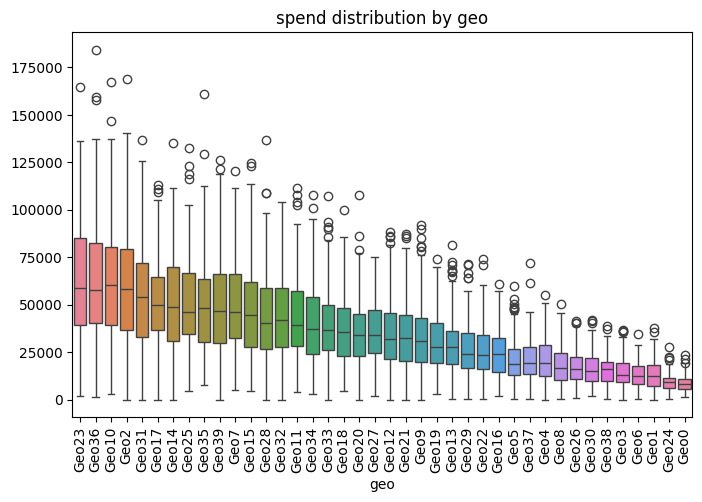

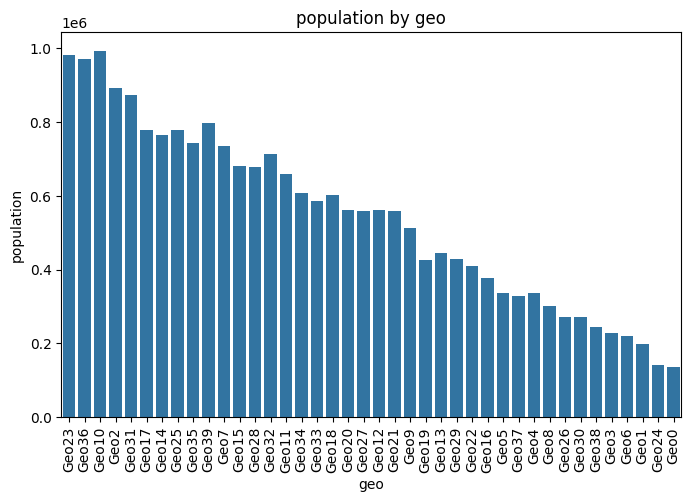

,spend_sum,population,revenue,spend_per_ppl,revenue_per_ppl,roas_per_ppl
count,4.000000e+01,40.000000,4.000000e+01,40.000000,40.000000,40.000000
mean,5.487310e+06,542418.832750,3.296749e+07,10.078750,60.303797,5.992771
std,2.520757e+06,245913.637234,1.582790e+07,0.360531,6.031765,0.658441
min,1.364015e+06,136670.940000,7.218458e+06,9.329216,50.612557,5.011163
25%,3.310522e+06,335176.345000,2.040368e+07,9.835725,56.212683,5.563858
50%,5.569653e+06,560478.825000,3.279129e+07,10.067499,59.282567,5.872460
75%,7.739039e+06,736033.810000,4.285809e+07,10.292102,63.444136,6.314248
max,9.937170e+06,994048.940000,6.581648e+07,10.999479,80.710093,8.265100


In [ ]:
## 2.check spend (distrubution)
geo_df = df.copy()
geo_df['total_spend'] = geo_df[col_spend].sum(axis=1)
geo_spend = pd.pivot(geo_df, index='time', columns='geo', values='total_spend')

geo_spend_sum = pd.DataFrame({'spend_sum':geo_spend.sum().sort_values(ascending=False)})
geo_spend = geo_spend[geo_spend_sum.index]
display(geo_spend.head())

plt.figure(figsize=(8,5))
plt.xticks(rotation=90)
plt.title('spend distribution by geo')
sns.boxplot(geo_spend)
plt.show()

## 3.check spend per ppl
geo_population = df.groupby('geo')\
        .agg({ 'population':'max',
            'revenue':'sum'})

geo_overview = pd.concat([geo_spend_sum, geo_population] ,axis=1)
geo_overview['spend_per_ppl'] = geo_overview['spend_sum']/geo_overview['population']
geo_overview['revenue_per_ppl'] = geo_overview['revenue']/geo_overview['population']
geo_overview['roas_per_ppl'] = geo_overview['revenue_per_ppl']/geo_overview['spend_per_ppl']


plt.figure(figsize=(8,5))
plt.xticks(rotation=90)
plt.title('population by geo')
sns.barplot(geo_overview['population'])
plt.show()

geo_overview.describe()

* all the geos run ch0~ch4 (ch2 has more zero spend).
* the spend volumn and variance become bigger based on the amount of population.
* the roas values (media effect) are similar across geos.


### check control
* whether control is scaled by geo level?
* whether controls effect media the same way across geo?
* ref: https://research.google/pubs/geo-level-bayesian-hierarchical-media-mix-modeling/

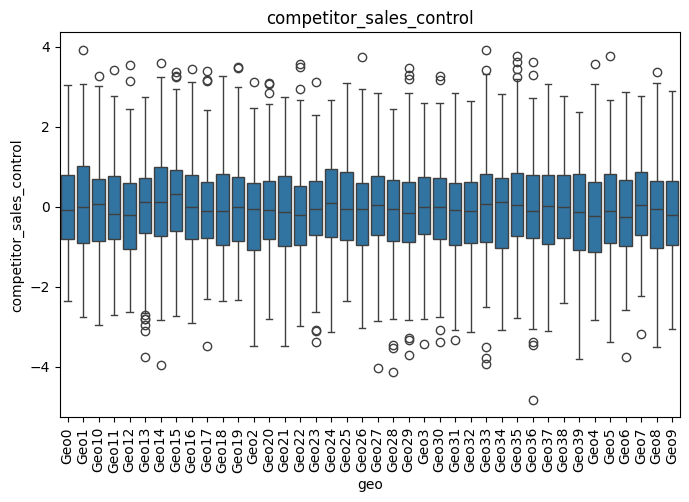

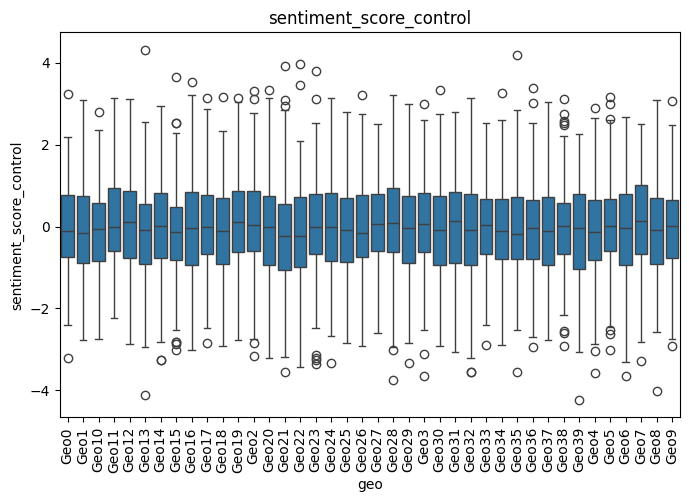

In [ ]:
for col in col_control:
  plt.figure(figsize=(8,5))
  plt.xticks(rotation=90)
  sns.boxplot(df,x='geo',y=col)
  plt.title(f'{col}')
  plt.show()


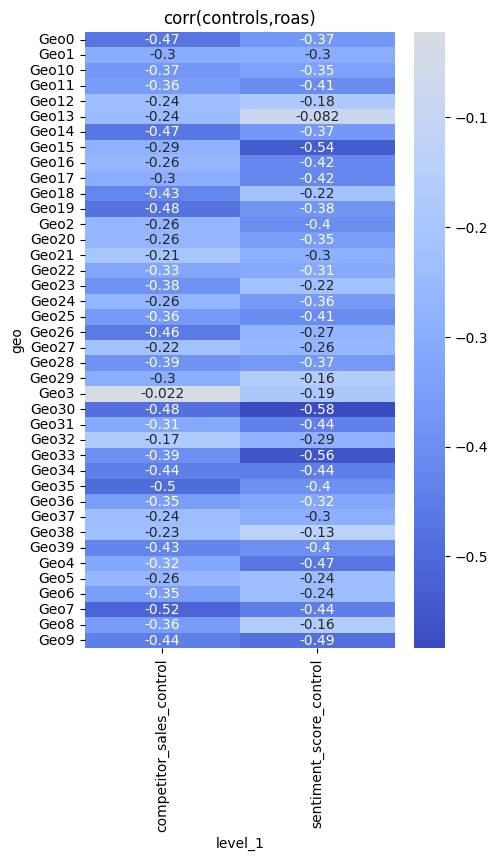

In [ ]:
control_df = df.copy()
control_df['spend_sum'] = control_df[col_spend].sum(axis=1)
control_df['roas'] = control_df['revenue']/control_df['spend_sum']

control_corr_data = control_df[col_control+['roas','geo']].groupby('geo').corr()['roas'].reset_index()
control_corr = pd.pivot_table(control_corr_data, index='geo', columns='level_1', values='roas').drop(columns='roas')

plt.figure(figsize=(5,8))
sns.heatmap(control_corr, annot=True, center=0, cmap='coolwarm')
plt.title('corr(controls,roas)')
plt.show()

* no futher geo scaling needed for controls.
* the relationships between controls and roas per ppl are similar across geos.

### Coord to columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6240 entries, 0 to 6239
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   geo                       6240 non-null   object        
 1   time                      6240 non-null   datetime64[ns]
 2   ch0_impression            6240 non-null   int64         
 3   ch1_impression            6240 non-null   int64         
 4   ch2_impression            6240 non-null   int64         
 5   ch3_impression            6240 non-null   int64         
 6   ch4_impression            6240 non-null   int64         
 7   competitor_sales_control  6240 non-null   float64       
 8   sentiment_score_control   6240 non-null   float64       
 9   ch0_spend                 6240 non-null   float64       
 10  ch1_spend                 6240 non-null   float64       
 11  ch2_spend                 6240 non-null   float64       
 12  ch3_spend                

In [ ]:
from meridian.data import data_frame_input_data_builder as data_builder

# cols other than media
builder = (
    data_builder.DataFrameInputDataBuilder(kpi_type='non_revenue')
        .with_kpi(df, kpi_col="conversions")
        .with_revenue_per_kpi(df, revenue_per_kpi_col="revenue_per_conversion")
        .with_population(df)
        .with_controls(df, control_cols=["competitor_sales_control", "sentiment_score_control"])
)


# cols for media
channels = ["ch0", "ch1", "ch2", "ch3", "ch4"]
builder = builder.with_media(
    df,
    media_cols=[f"{channel}_impression" for channel in channels],
    media_spend_cols=[f"{channel}_spend" for channel in channels],
    media_channels=channels,
)

# cols for no-spend treatment (organic media & non media)
builder = builder.with_organic_media(
  df,
  organic_media_cols = ["organic_ch0_impression"],
  organic_media_channels = ["organic_ch0"],
  media_time_col = "time"
).with_non_media_treatments(
  df,
  non_media_treatment_cols=['promo']
)

# build data
data = builder.build()
for attr_name, da in data.__dict__.items():
  print(f'attr: {attr_name}, {type(da)}')

attr: kpi, <class 'xarray.core.dataarray.DataArray'>
attr: kpi_type, <class 'str'>
attr: population, <class 'xarray.core.dataarray.DataArray'>
attr: controls, <class 'xarray.core.dataarray.DataArray'>
attr: revenue_per_kpi, <class 'xarray.core.dataarray.DataArray'>
attr: media, <class 'xarray.core.dataarray.DataArray'>
attr: media_spend, <class 'xarray.core.dataarray.DataArray'>
attr: reach, <class 'NoneType'>
attr: frequency, <class 'NoneType'>
attr: rf_spend, <class 'NoneType'>
attr: organic_media, <class 'xarray.core.dataarray.DataArray'>
attr: organic_reach, <class 'NoneType'>
attr: organic_frequency, <class 'NoneType'>
attr: non_media_treatments, <class 'xarray.core.dataarray.DataArray'>
attr: time_coordinates, <class 'meridian.data.time_coordinates.TimeCoordinates'>
attr: media_time_coordinates, <class 'meridian.data.time_coordinates.TimeCoordinates'>


<a name="configure-model"></a>
## Step 2: Configure the model

Meridian uses Bayesian framework and Markov Chain Monte Carlo (MCMC) algorithms to sample from the posterior distribution.

1\. Inititalize the `Meridian` class by passing the loaded data and the customized model specification. One advantage of Meridian lies in its capacity to calibrate the model directly through ROI priors, as described in [Media Mix Model Calibration With Bayesian Priors](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/). In this particular example, the ROI priors for all media channels are identical, with each being represented as Lognormal(0.2, 0.9).

In [ ]:
np.random.seed(1)
test_pct = 0.08  # 10% of data are held out
n_geos = len(data.geo)
n_times = len(data.time)
holdout_id = np.full([n_geos, n_times], False)

for i in range(n_geos):
  holdout_id[i, np.random.choice(n_times, int(np.round(test_pct * n_times)))] = (True)

# if national model
national_model = len(df['geo'].unique())<2
if national_model:
  holdout_id = holdout_id.T.reshape(-1)
else:
  holdout_id = holdout_id

print(f'testing split size:{holdout_id.sum()}')
print(f'testing split shape:{holdout_id.shape}')

testing split size:468
testing split shape:(40, 156)


In [ ]:
# setting roi prior
roi_mu  = 0.2    # Mu for ROI prior for each media channel.
roi_sigma = 0.9  # Sigma for ROI prior for each media channel.

prior_dist = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M))

# model spec
model_spec = spec.ModelSpec(
    prior=prior_dist,
    media_effects_dist='log_normal',
    hill_before_adstock=False,
    max_lag=8,
    unique_sigma_for_each_geo=True,
    media_prior_type='roi',
    roi_calibration_period=None,
    # rf_prior_type='roi',
    # rf_roi_calibration_period=None,
    organic_media_prior_type='contribution',
    # organic_rf_prior_type='contribution',
    non_media_treatments_prior_type='contribution',
    knots=None,
    baseline_geo=None,
    holdout_id=holdout_id,
    control_population_scaling_id=None,
)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

In [ ]:
model.prior_distribution.PriorDistribution.__init__

<function meridian.model.prior_distribution.PriorDistribution.__init__(self, *, knot_values: 'tfp.distributions.Distribution' = <factory>, tau_g_excl_baseline: 'tfp.distributions.Distribution' = <factory>, beta_m: 'tfp.distributions.Distribution' = <factory>, beta_rf: 'tfp.distributions.Distribution' = <factory>, beta_om: 'tfp.distributions.Distribution' = <factory>, beta_orf: 'tfp.distributions.Distribution' = <factory>, eta_m: 'tfp.distributions.Distribution' = <factory>, eta_rf: 'tfp.distributions.Distribution' = <factory>, eta_om: 'tfp.distributions.Distribution' = <factory>, eta_orf: 'tfp.distributions.Distribution' = <factory>, gamma_c: 'tfp.distributions.Distribution' = <factory>, gamma_n: 'tfp.distributions.Distribution' = <factory>, xi_c: 'tfp.distributions.Distribution' = <factory>, xi_n: 'tfp.distributions.Distribution' = <factory>, alpha_m: 'tfp.distributions.Distribution' = <factory>, alpha_rf: 'tfp.distributions.Distribution' = <factory>, alpha_om: 'tfp.distributions.Dist

2\. Use the `sample_prior()` and `sample_posterior()` methods to obtain samples from the prior and posterior distributions of model parameters. If you are using the T4 GPU runtime this step may take about 10 minutes for the provided data set.

In [ ]:
%%time
mmm.sample_prior(500)
mmm.sample_posterior(n_chains=3, n_adapt=500, n_burnin=500, n_keep=1000)

CPU times: user 10min 59s, sys: 24.5 s, total: 11min 23s
Wall time: 11min 25s


For more information about configuring the parameters and using a customized model specification, such as setting different ROI priors for each media channel, see [Configure the model](https://developers.google.com/meridian/docs/user-guide/configure-model).

<a name="model-diagnostics"></a>
## Step 3: Run model diagnostics

After the model is built, you must assess convergence, debug the model if needed, and then assess the model fit.

1\. Assess convergence. Run the following code to generate r-hat statistics. R-hat close to 1.0 indicate convergence. R-hat < 1.2 indicates approximate convergence and is a reasonable threshold for many problems.

In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

2\. Assess the model's fit by comparing the expected sales against the actual sales.

For more information and additional model diagnostics checks, see [Modeling diagnostics](https://developers.google.com/meridian/docs/user-guide/model-diagnostics).

In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

,metric,geo_granularity,evaluation_set,value
0,R_Squared,geo,Train,0.779824
1,R_Squared,geo,Test,0.730753
2,R_Squared,geo,All Data,0.776235
3,R_Squared,national,Train,0.951416
4,R_Squared,national,Test,0.936486
5,R_Squared,national,All Data,0.908277
6,MAPE,geo,Train,0.251757
7,MAPE,geo,Test,0.286114
8,MAPE,geo,All Data,0.254333
9,MAPE,national,Train,0.014583


In [ ]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit(
    # n_top_largest_geos=3,
    # show_geo_level=True,
    include_baseline=True,
    include_ci=True)

alt.LayerChart(...)

In [ ]:
# mmm.inference_data.posterior.to_netcdf('posterior.nc')
mmm.inference_data

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> trace

In [ ]:
mmm.inference_data.posterior.gamma_c

<xarray.DataArray 'gamma_c' (chain: 3, draw: 1000, control_variable: 2)> Size: 24kB
array([[[-0.21991101, -0.00581174],
        [-0.2161326 , -0.12025157],
        [-0.2196829 , -0.08132886],
        ...,
        [-0.37005907, -0.12348713],
        [-0.30720448, -0.14996953],
        [-0.3003099 , -0.14021018]],

       [[-0.37217158, -0.05222104],
        [-0.24787456, -0.05129017],
        [-0.24407917, -0.06343262],
        ...,
        [-0.47235954, -0.07454609],
        [-0.47396344, -0.08164404],
        [-0.52870256, -0.11660971]],

       [[-0.21202923, -0.00530592],
        [-0.2469183 , -0.00995785],
        [-0.19794297,  0.0108404 ],
        ...,
        [-0.36548197, -0.07629284],
        [-0.37107992, -0.08268025],
        [-0.37713015, -0.05432875]]], dtype=float32)
Coordinates:
  * chain             (chain) int64 24B 0 1 2
  * draw              (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * control_variable  (control_variable) object 16B 'competitor_sales_control...

,chain,draw,control_variable,value
0,0,0,competitor_sales_control,-0.22
1,0,0,sentiment_score_control,-0.01
2,0,1,competitor_sales_control,-0.22
3,0,1,sentiment_score_control,-0.12
4,0,2,competitor_sales_control,-0.22
...,...,...,...,...
5995,2,997,sentiment_score_control,-0.08
5996,2,998,competitor_sales_control,-0.37
5997,2,998,sentiment_score_control,-0.08
5998,2,999,competitor_sales_control,-0.38


Text(0.5, 1.0, 'posterior')

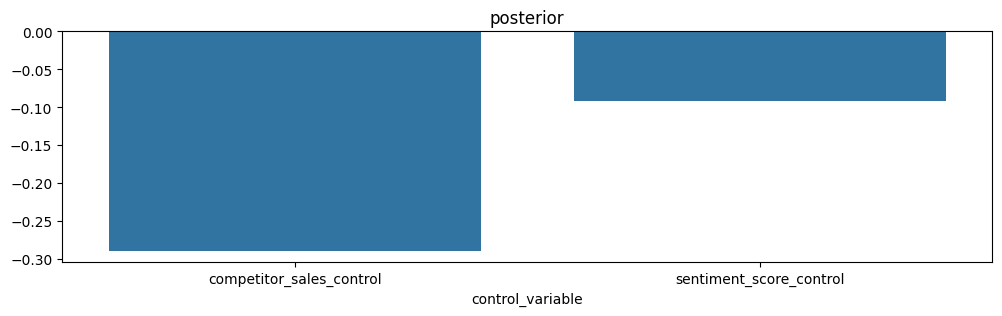

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

var = mmm.inference_data.posterior.gamma_c  #change to cpmpare prior/posterior
index = 'control_variable'

var_df = var.to_dataframe(name="value").reset_index()
display(var_df)

var_table = pd.pivot_table(var_df, values='value', index=['draw'], columns=[index])
var_table = var_table.groupby('draw').mean()

plt.figure(figsize=(12,3))
sns.barplot(var_table.mean())
plt.title('posterior')

,chain,draw,control_variable,value
0,0,0,competitor_sales_control,0.60
1,0,0,sentiment_score_control,1.97
2,0,1,competitor_sales_control,2.55
3,0,1,sentiment_score_control,2.54
4,0,2,competitor_sales_control,1.66
...,...,...,...,...
995,0,497,sentiment_score_control,-1.63
996,0,498,competitor_sales_control,-3.82
997,0,498,sentiment_score_control,7.00
998,0,499,competitor_sales_control,-6.90


Text(0.5, 1.0, 'prior')

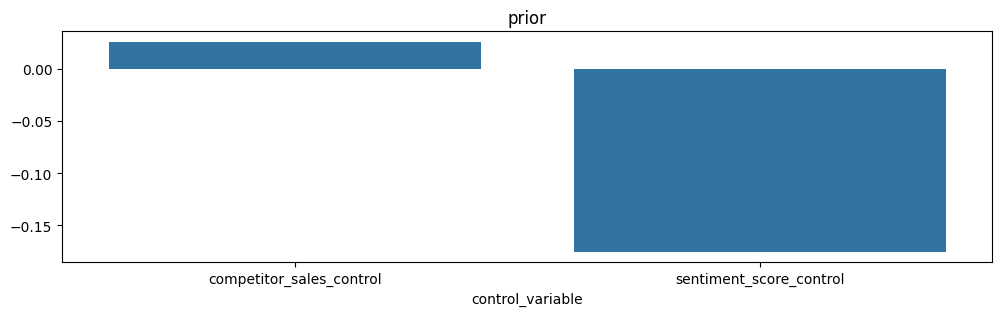

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

var = mmm.inference_data.prior.gamma_c  #change to cpmpare prior/posterior
index = 'control_variable'

var_df = var.to_dataframe(name="value").reset_index()
display(var_df)

var_table = pd.pivot_table(var_df, values='value', index=['draw'], columns=[index])
var_table = var_table.groupby('draw').mean()

plt.figure(figsize=(12,3))
sns.barplot(var_table.mean())
plt.title('prior')


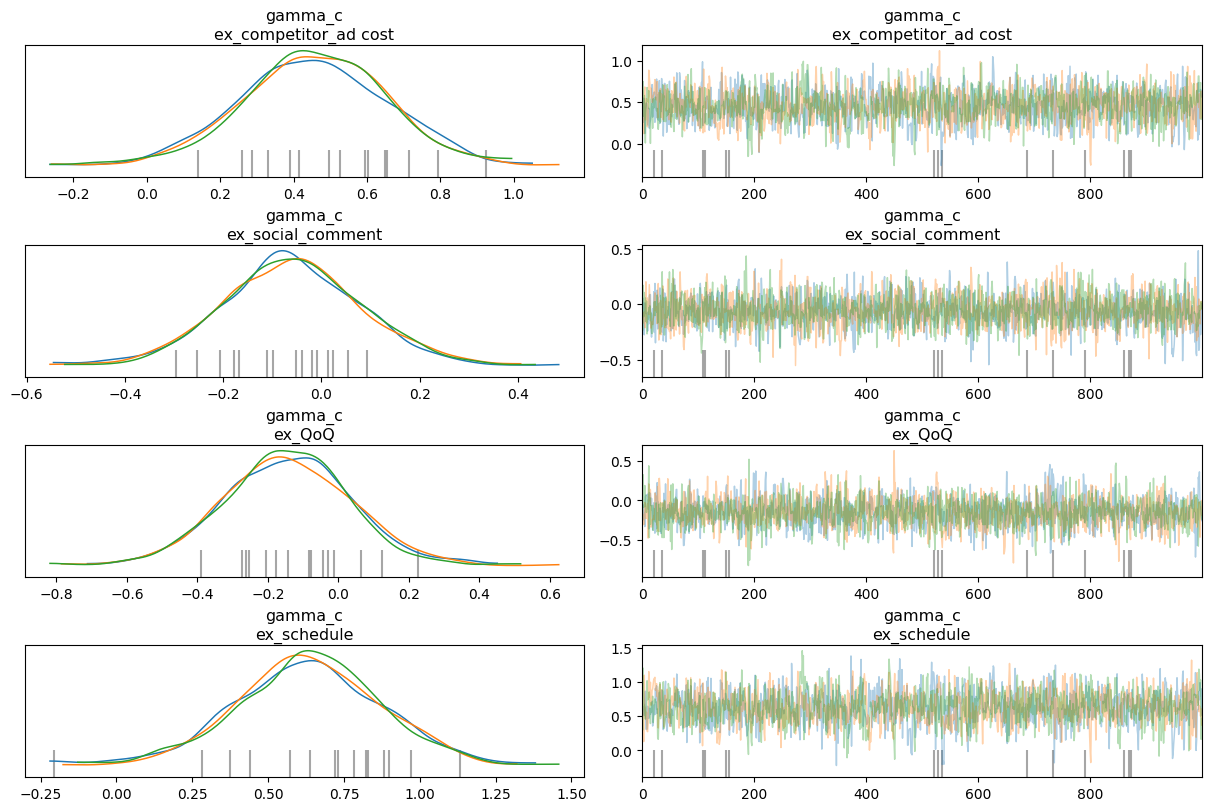

In [ ]:
parameters_to_plot=['gamma_c'] # change to see different dist.
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

<a name="generate-summary"></a>
## Step 4: Generate model results & two-page output

To export the two-page HTML summary output, initialize the `Summarizer` class with the model object. Then pass in the filename, filepath, start date, and end date to `output_model_results_summary` to run the summary for that time duration and save it to the specified file.

In [ ]:
# media summary
media_summary = visualizer.MediaSummary(mmm)
waterfall_chart = media_summary.plot_contribution_waterfall_chart()
summary_table = media_summary.summary_table()
display(waterfall_chart)
display(summary_table)

alt.LayerChart(...)

,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,ch0,prior,"5,523,420,160",20%,"$40,501,712",18%,$7,"$76,723,000 ($13,388,871, $213,231,776)","4.5% (0.8%, 12.6%)","1.9 (0.3, 5.3)","0.01 (0.00, 0.04)","0.9 (0.1, 2.9)","$0.0 ($0.0, $0.1)"
1,ch0,posterior,"5,523,420,160",20%,"$40,501,712",18%,$7,"$68,499,648 ($18,018,446, $139,476,368)","5.2% (1.4%, 10.6%)","1.7 (0.4, 3.4)","0.01 (0.00, 0.03)","0.8 (0.2, 1.8)","$0.0 ($0.0, $0.0)"
2,ch1,prior,"3,248,578,560",12%,"$31,320,302",14%,$10,"$52,596,628 ($8,023,072, $164,396,144)","3.1% (0.5%, 9.7%)","1.7 (0.3, 5.2)","0.02 (0.00, 0.05)","0.8 (0.1, 2.5)","$0.0 ($0.0, $0.1)"
3,ch1,posterior,"3,248,578,560",12%,"$31,320,302",14%,$10,"$31,705,692 ($8,167,047, $69,878,552)","2.4% (0.6%, 5.3%)","1.0 (0.3, 2.2)","0.01 (0.00, 0.02)","0.5 (0.1, 1.1)","$0.0 ($0.0, $0.1)"
4,ch2,prior,"1,625,551,360",6%,"$12,079,349",6%,$7,"$21,400,574 ($3,489,650, $67,849,760)","1.3% (0.2%, 4.0%)","1.8 (0.3, 5.6)","0.01 (0.00, 0.04)","1.0 (0.1, 3.4)","$0.0 ($0.0, $0.1)"
5,ch2,posterior,"1,625,551,360",6%,"$12,079,349",6%,$7,"$17,838,224 ($7,401,596, $31,494,930)","1.4% (0.6%, 2.4%)","1.5 (0.6, 2.6)","0.01 (0.00, 0.02)","0.8 (0.3, 1.6)","$0.0 ($0.0, $0.0)"
6,ch3,prior,"11,274,498,048",41%,"$87,860,352",40%,$8,"$158,142,176 ($21,868,804, $488,788,256)","9.3% (1.3%, 28.8%)","1.8 (0.2, 5.6)","0.01 (0.00, 0.04)","0.9 (0.1, 2.7)","$0.0 ($0.0, $0.1)"
7,ch3,posterior,"11,274,498,048",41%,"$87,860,352",40%,$8,"$86,243,808 ($32,187,032, $162,200,656)","6.5% (2.4%, 12.3%)","1.0 (0.4, 1.8)","0.01 (0.00, 0.01)","0.5 (0.2, 0.9)","$0.0 ($0.0, $0.1)"
8,ch4,prior,"6,125,670,400",22%,"$47,730,680",22%,$8,"$81,816,144 ($12,637,518, $236,838,000)","4.8% (0.7%, 13.9%)","1.7 (0.3, 5.0)","0.01 (0.00, 0.04)","0.9 (0.1, 2.5)","$0.0 ($0.0, $0.1)"
9,ch4,posterior,"6,125,670,400",22%,"$47,730,680",22%,$8,"$96,283,592 ($27,694,000, $201,294,192)","7.3% (2.1%, 15.2%)","2.0 (0.6, 4.2)","0.02 (0.00, 0.03)","0.9 (0.2, 1.6)","$0.0 ($0.0, $0.0)"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datetime import datetime
import pytz

topic = 'simulated data'
timestamp = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%m%d%H%M")
file_name = f'meridian_{topic}_{timestamp}.html'

start_date = str(df['time'].min().date())
end_date = str(df['time'].max().date())

filepath = '/content/drive/MyDrive/meridian'

mmm_summarizer = summarizer.Summarizer(mmm)
mmm_summarizer.output_model_results_summary(
                      file_name, filepath,
                      # start_date, end_date
                      )

print(f'【 {file_name} 】 done:)')

【 meridian_simulated data_07141412.html 】 done:)


Here is a preview of the two-page output based on the simulated data:

In [ ]:
IPython.display.HTML(filename='/content/drive/MyDrive/meridian/%s'%file_name)

Dataset,R-squared,MAPE,wMAPE
Training Data,0.95,1%,1%
Testing Data,0.94,15%,12%
All Data,0.91,2%,2%


For a customized two-page report, model results summary table, and individual visualizations, see [Model results report](https://developers.google.com/meridian/docs/user-guide/generate-model-results-report) and [plot media visualizations](https://developers.google.com/meridian/docs/user-guide/plot-media-visualizations).





<a name="generate-optimize"></a>
## Step 5: Run budget optimization & generate an optimization report

You can choose what scenario to run for the budget allocation. In default scenario, you find the optimal allocation across channels for a given budget to maximize the return on investment (ROI).

1\. Instantiate the `BudgetOptimizer` class and run the `optimize()` method without any customization, to run the default library's Fixed Budget Scenario to maximize ROI.

In [ ]:
%%time
budget_optimizer = optimizer.BudgetOptimizer(mmm)

optimization_results = budget_optimizer.optimize(
  use_kpi=True,
  fixed_budget=True,
  # target_mroi=0.01,
  # selected_times=('2024-05-06', '2024-06-24'),
  # budget=1000000,
  # pct_of_spend=[0.2, 0.2, 0.2, 0.1, 0.2, 0.1],
  # spend_constraint_lower=1,
  # spend_constraint_upper=1,
)

CPU times: user 31.1 s, sys: 1.32 s, total: 32.4 s
Wall time: 32.9 s


2\. Export the 2-page HTML optimization report, which contains optimized spend allocations and ROI.

In [ ]:
filepath = '/content/drive/MyDrive/meridian'
timestamp = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%m%d%H%M")

usage = 'fixed'
opt_file_name = f'meridian_{topic}_{timestamp}_{usage}_opt.html'
optimization_results.output_optimization_summary(opt_file_name, filepath)

In [ ]:
IPython.display.HTML(filename='/content/drive/MyDrive/meridian/%s'%opt_file_name)

Channel,Non-optimized spend,Optimized spend
ch3,40%,30%
ch4,22%,28%
ch0,18%,24%
ch1,14%,11%
ch2,6%,7%
